In [162]:
import importlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

import Helper_Build_UNet_Model
import Helper_Create_Postprocessing_Model
import Helper_Calc_Mean_Alias_Value_Of_One_Image 

importlib.reload(Helper_Build_UNet_Model)
importlib.reload(Helper_Create_Postprocessing_Model)
importlib.reload(Helper_Calc_Mean_Alias_Value_Of_One_Image)

from Helper_Build_UNet_Model import build_unet_model
from Helper_Create_Postprocessing_Model import create_postprocessing_model, tf_inv_fourier_trans
from Helper_Calc_Mean_Alias_Value_Of_One_Image import calc_mean_alias_value_of_one_image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images

import time


In [163]:
model_cnn = tf.keras.models.load_model("./cnn_models/single_rgb_image_regression_V02_epochs_100_1653595623")


In [164]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [165]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [166]:
train_filmed_imgs = []
train_clean_imgs = []

In [167]:
OFFSET = 200
abbruch_idx = 30


def my_train_filmed_gen():
    for i, addr_filmed in enumerate(os.listdir(TRAIN_FILMED_PATH)):
        img =  plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]

def my_train_clean_gen():
    for i, addr_clean in enumerate(os.listdir(TRAIN_CLEAN_PATH)):
        img =  plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]


train_filmed_img_gen_obj = my_train_filmed_gen()
train_clean_img_gen_obj = my_train_clean_gen()

## Build U-Net-Model

In [168]:
model_u_net = build_unet_model(IMG_WIDTH, IMG_HEIGHT)
# model_u_net.summary()


# Build Postprecessing Model

In [169]:
postprocessing_model = create_postprocessing_model()
# postprocessing_model.summary()


++++++++++++++++++++++++++++ Betrete Softblenging!!
++++++++++++++++++++++++++++ Betrete Softblenging!!
++++++++++++++++++++++++++++ Betrete Softblenging!!


## Custom Train loop


In [170]:
# Custom train loop

SAFE_RESULTS = True
WRITE_PATH = "D:\\Main\\MA_PROGR\\Data\\UNET_Output\\Session08"

show_intermediate_pics = False

RGB_WEIGHTS = [0.299, 0.587, 0.114]


overall_train_loss = []


execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
execute_postprocessing_model = tf.function(postprocessing_model)

NUM_EPOCHS = 1
batch_size_cnn = 1
batch_size_unet = 5


optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanAbsoluteError()
epoch_loss = tf.keras.metrics.MeanAbsoluteError()


train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")

jump_to_new_epoch = False

for epoch in range(NUM_EPOCHS):

    print(f"Start of epoch {epoch}")
    jump_to_new_epoch = False

    # Mache neue Generater, sodass wieder durch alle Bilder durchgegange wird für die nächste Epoche:
    train_filmed_img_gen_obj = my_train_filmed_gen()
    train_clean_img_gen_obj = my_train_clean_gen()

    # ---------------------------------------------------------------------------- BATCHES SAMMELN Start ----------------------------------------------------------------------------------------
    train_step = 0

    for batch_idx in tqdm(range(batch_size_unet), desc="training...", ascii=False, ncols=75):
        print("next batch...")
        cnn_mean_prediction_values = []

        with tf.GradientTape() as tape:

            # Bilder für den nächsten Batch sammeln:
            for i in range(batch_size_unet):
                try:
                    x_filmed = train_filmed_img_gen_obj.__next__()
                    x_clean = train_clean_img_gen_obj.__next__()
                except StopIteration as e:
                    print(
                        "------------------------Am Ende angelangt, gehe in neue Epoche")

                    jump_to_new_epoch = True

                if jump_to_new_epoch == True:
                    # Alle Bilder sind aufgebraucht, gehe in neue Epoche
                    break

                y_pred, differenzbild_fourier_px, u_net_output, image_processed_rgb = calc_mean_alias_value_of_one_image(
                    x_filmed,
                    x_clean,
                    show_intermediate_pics,
                    IMG_WIDTH,
                    IMG_HEIGHT,
                    execute_postprocessing_model,
                    execute_cnn_model,
                    execute_UNet_model
                )
                cnn_mean_prediction_values.append(y_pred)

                # print("y_pred: ")
                # print(y_pred)

                # ---------------------------------------------------------------------------- BATCHES SAMMELN ENDE ----------------------------------------------------------------------------------------


            if SAFE_RESULTS:
                plt.imsave(
                    f"{WRITE_PATH}\\x_filmed_{epoch}_{batch_idx}.png", x_filmed)
                plt.imsave(
                    f"{WRITE_PATH}\\x_clean_{epoch}_{batch_idx}.png", x_clean)

                plt.imsave(f"{WRITE_PATH}\\differenzbild_{epoch}_{batch_idx}.png",
                           differenzbild_fourier_px.reshape((IMG_WIDTH, IMG_HEIGHT)), cmap="gray")



                u_net_output_for_img_save = np.array(u_net_output).reshape(IMG_WIDTH, IMG_HEIGHT)
                # print("---------------> u_net_output_for_img_save")
                # print(u_net_output_for_img_save)
                plt.imsave(f"{WRITE_PATH}\\unet_output_{epoch}_{batch_idx}.png",
                           u_net_output_for_img_save, cmap="gray")

                # image_processed_rgb umformen in Numpy-Array
                image_processed_rgb_for_img_save = np.array(
                    image_processed_rgb).reshape((IMG_WIDTH, IMG_HEIGHT, 3))
                try:
                    plt.imsave(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.png", image_processed_rgb_for_img_save)
                except ValueError:
                    print("------------------------- Speichern hat nicht geklappt, speichere stattdessen numpy array zur Inspektion:")
                    np.save(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.npy", image_processed_rgb_for_img_save)


            if jump_to_new_epoch == True:
                # Alle Bilder sind aufgebraucht, gehe in neue epoche
                break

            # ----------- Calc loss for one batch -----------

            y_true = tf.zeros(batch_size_unet, 1)

            # print("cnn_mean_prediction_values.shape: ")
            # print(np.array(cnn_mean_prediction_values).shape)

            loss = loss_fn(y_true=y_true, y_pred=cnn_mean_prediction_values)
            # print("loss for one batch: ")
            # print(loss)

            gradients = tape.gradient(loss, model_u_net.trainable_weights)
            del cnn_mean_prediction_values[:]
            # print("gradients: ")
            # print(gradients)

            # Optimize the model:
            optimizer.apply_gradients(
                zip(gradients, model_u_net.trainable_variables))

            tmp = epoch_loss.update_state(y_true, y_pred)

            # print("tmp")
            # print(tmp)

            # print("------------------------------------")
            # print("y_true:")
            # print(y_true)

            # print("y_pred")
            # print(y_pred)
            # print("------------------------------------")

            # with train_writer.as_default():
            #     tf.summary.scalar("Loss", loss, step=train_step)
            #     tf.summary.scalar(
            #         "Accuracy", epoch_loss.result(), step=train_step,
            #     )
            # train_step += 1

        # End Epoch

        print(f"--------------- epoch_loss: {epoch_loss.result()}")
        overall_train_loss.append(epoch_loss.result())


# overall_train_loss = epoch_loss.result()
# print(f"overall_train_loss: {overall_train_loss}")
# epoch_loss.reset_states()


Start of epoch 0


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...


training...:  20%|█████▍                     | 1/5 [00:06<00:25,  6.29s/it]

--------------- epoch_loss: 0.25830909609794617
next batch...


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.12s/it]

--------------- epoch_loss: 0.20292671024799347
next batch...


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.75s/it]

--------------- epoch_loss: 0.2173854559659958
next batch...


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.57s/it]

--------------- epoch_loss: 0.19961762428283691
next batch...


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.72s/it]

--------------- epoch_loss: 0.19683201611042023


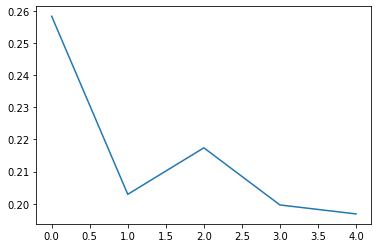

In [171]:

plt.plot(overall_train_loss)

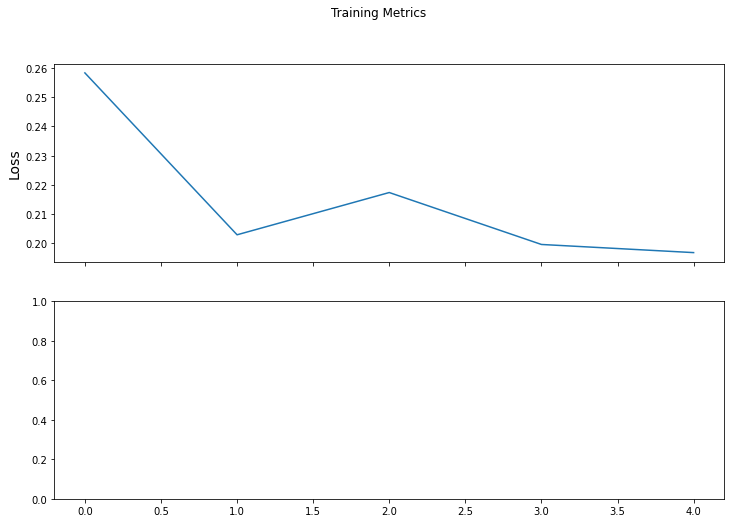

In [172]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(overall_train_loss)

plt.show()


In [173]:
# test_img = img[400:528, 400:528,:]
# test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# # plt.imshow(test_img)

# test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

# test_img


In [174]:
# import tensorflow as tf
# BATCH_SIZE = 1
# NUM_BOXES = 3
# IMAGE_HEIGHT = 128
# IMAGE_WIDTH = 128
# CHANNELS = 3
# CROP_SIZE = (24, 24)

# test_img = img[400:528, 400:528, :]
# test_img = np.array(test_img).reshape(1, 128, 128, 3)

# # plt.imshow(test_img)

# test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
# image = test_img
# boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# # plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# # plt.show()
# box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
#                                 maxval=BATCH_SIZE, dtype=tf.int32)
# output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
# output.shape  # => (5, 24, 24, 3)

# plt.imshow(output[2])
